### HW4 Assignment Disclaimer
*	Author Name: V Harsha Yellela
*	LTU ID: 000798754
*	Work Ownership: This work is my own. It is not copied from classmates (Yes/No): Yes
*	AI Assistance: Percentage of code generated with AI tools
(If greater than 0%, briefly describe how AI was used): 15% (for code formatting and clarification only)
*	Understanding: I understand every part of this code (Yes/No):  Yes
*	Confidence: I am confident that I can modify, adapt, and extend this code on my own (Yes/No): Yes

## XOR with 3 classes

<pre>
   | x0 | x1 |XOR3|
   |----|----|----|
   |0.0 |0.0 | 0  |
   |0.0 |1.0 | 1  |
   |1.0 |0.0 | 1  |
   |1.0 |1.0 | 0  |
   |0.5 |0.5 | 2  |
</pre>

In [1]:
import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build

print("✅ TensorFlow version:", tf.__version__)
print("🧩 Build:", "CUDA" if tf_build.build_info.get("is_cuda_build") else "CPU-only")

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("💻 Detected GPUs:", gpus)

# Optional: print CUDA/cuDNN versions TensorFlow is using
print("🔹 CUDA version:", tf_build.build_info.get("cuda_version", "N/A"))
print("🔹 cuDNN version:", tf_build.build_info.get("cudnn_version", "N/A"))

✅ TensorFlow version: 2.10.1
🧩 Build: CUDA
💻 Detected GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
🔹 CUDA version: 64_112
🔹 cuDNN version: 64_8


In [2]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# the five different states of the XOR3 gate
X = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5],[0.6,0.6]])

# the five expected results in the same order
y = np.array([[0],[1],[1],[0],[2],[2]])

Xt = np.array([[0,0.1],[0.1,1],[0.9,0],[0.9,1],[0.55,0.45]])
yt = np.array([[0],[1],[1],[0],[2]])

In [3]:
act_func = ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
optimz = ('SGD', 'RMSprop', 'Adam')
loss_func = 'sparse_categorical_crossentropy'

print("Activation functions:", act_func)
print("Optimizers:", optimz)
print("Loss function:", loss_func)

Activation functions: ('relu', 'elu', 'sigmoid', 'tanh', 'leaky_relu')
Optimizers: ('SGD', 'RMSprop', 'Adam')
Loss function: sparse_categorical_crossentropy


In [4]:
# Using 'sparse_categorical_crossentropy'
def XOR3_eval(param):
    """
    param indices:
      0: num of hidden neurons
      1: learning rate
      2: batch size
      3: activation function index
      4: Epochs
      5: optimizer index
    """
    global model
    model = Sequential([
        keras.Input(shape=(2,)),
        Dense(int(param[0]), activation=act_func[round(param[3])]),
        Dense(3, activation='softmax')
    ])

    if round(param[5]) == 0:
        optmzr = optimizers.SGD(learning_rate=param[1])
    elif round(param[5]) == 1:
        optmzr = optimizers.RMSprop(learning_rate=param[1])
    else:
        optmzr = optimizers.Adam(learning_rate=param[1])

    model.compile(
    optimizer=optmzr,
    loss=loss_func, # target labels are integers
    metrics=['accuracy']
    )
    model.fit(X, y, batch_size=int(param[2]), epochs=int(param[4]), verbose=0)

    loss, acc = model.evaluate(Xt, yt, verbose=0)
    return loss
    # score = loss + (1 - acc) # minimize error and  loss
    # return score
    # return 1-acc

# test_param = [4, 0.5, 2, 2, 0, 1]  # neurons, lr, bsize, act='sigmoid', loss, opt='RMSprop'
# print("loss =", XOR3_eval(test_param))

In the initial version, the objective function used validation loss as the optimization metric.
However, during experimentation (see figure below), the model converged to a degenerate solution where all input samples were classified into a single class (Class 2).
Although this produced a small numerical loss (≈ 0.002), the prediction accuracy was poor, demonstrating that low loss does not necessarily indicate correct class separation.

To prevent this issue, the objective function was modified to minimize the classification error ( 1 − accuracy ) and loss instead of only the loss value.
By optimizing for accuracy, the evolutionary search (ES (1+1) with 1/5 rule) avoids premature convergence to trivial solutions and ensures that acceptable models correctly learn all three XOR3 classes rather than collapsing to a single output.

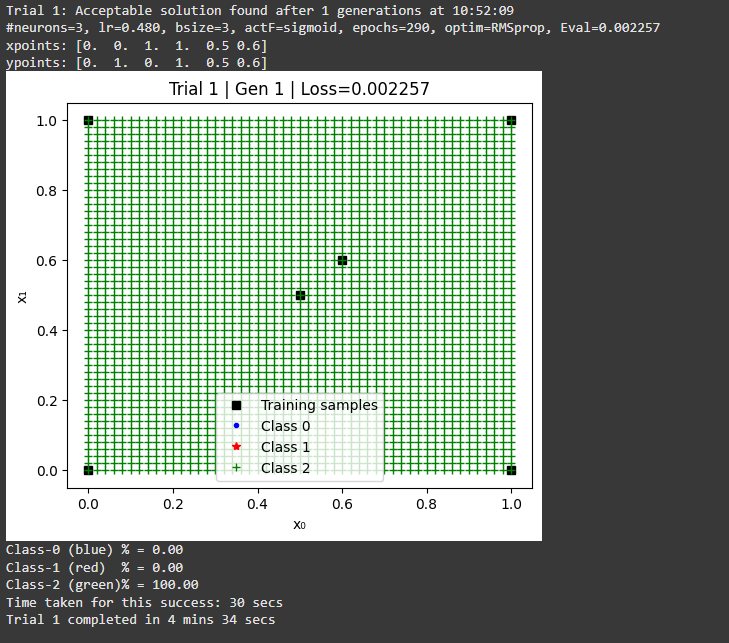


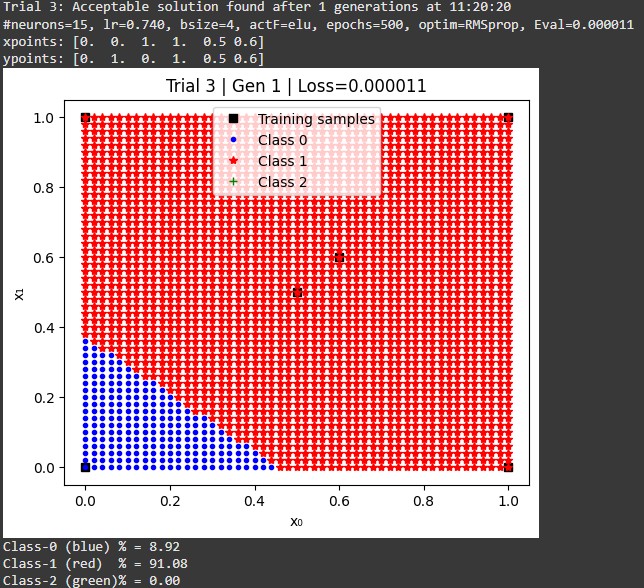

In [5]:
def print_HP_found(x, eval):
    print(
        f"#neurons={int(x[0])}, "
        f"lr={x[1]:.3f}, "
        f"bsize={int(x[2])}, "
        f"actF={act_func[int(round(x[3]))]}, "
        f"epochs={int(x[4])}, "
        f"optim={optimz[int(round(x[5]))]}, "
        f"Eval={eval:.6f}"
    )

In [6]:
def boundary_coverage_ok(model, min_pct=0.05):
    xs = np.arange(0.0, 1.02, 0.02)
    ys = np.arange(0.0, 1.02, 0.02)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = np.argmax(model.predict(grid, verbose=0), axis=1)
    counts = np.bincount(preds, minlength=3)
    total = counts.sum()
    return np.all(counts / total >= min_pct), counts / total

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

def plot_XOR3_decision_boundary(model=None, model_path=None, title="Decision Boundary for XOR3"):
    # Load from file if a path is given
    if model is None and model_path is not None:
        model = load_model(model_path)

    # Extract training samples for plotting
    xpoint = X[:, 0]
    ypoint = X[:, 1]
    print("xpoints:", xpoint)
    print("ypoints:", ypoint)

    # Prepare storage for predicted class coordinates
    xp_cls0, yp_cls0 = np.array([]), np.array([])
    xp_cls1, yp_cls1 = np.array([]), np.array([])
    xp_cls2, yp_cls2 = np.array([]), np.array([])
    num0 = num1 = num2 = 0

    # Scan 2D grid [0,1]×[0,1]
    for x in np.arange(0.0, 1.02, 0.02):
        for y in np.arange(0.0, 1.02, 0.02):
            xy = np.array([[x, y]], dtype=np.float32)
            pred = np.argmax(model.predict(xy, verbose=0))
            if pred == 0:
                xp_cls0 = np.append(xp_cls0, x)
                yp_cls0 = np.append(yp_cls0, y)
                num0 += 1
            elif pred == 1:
                xp_cls1 = np.append(xp_cls1, x)
                yp_cls1 = np.append(yp_cls1, y)
                num1 += 1
            else:
                xp_cls2 = np.append(xp_cls2, x)
                yp_cls2 = np.append(yp_cls2, y)
                num2 += 1

    # --- Plot the decision regions ---
    plt.figure(figsize=(6, 5))
    plt.plot(xpoint, ypoint, 'ks', label='Training samples')
    plt.plot(xp_cls0, yp_cls0, 'b.', label='Class 0')
    plt.plot(xp_cls1, yp_cls1, 'r*', label='Class 1')
    plt.plot(xp_cls2, yp_cls2, 'g+', label='Class 2')
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.legend()
    plt.show()

    # --- Print class percentages ---
    total = num0 + num1 + num2
    print(f"Class-0 (blue) % = {num0/total*100:.2f}")
    print(f"Class-1 (red)  % = {num1/total*100:.2f}")
    print(f"Class-2 (green)% = {num2/total*100:.2f}")

In [8]:
def format_time(seconds):
    """Return time in 'hh hrs mm mins ss secs' format."""
    seconds = int(seconds)
    hrs, rem = divmod(seconds, 3600)
    mins, secs = divmod(rem, 60)
    parts = []
    if hrs > 0:
        parts.append(f"{hrs} hr{'s' if hrs>1 else ''}")
    if mins > 0:
        parts.append(f"{mins} min{'s' if mins>1 else ''}")
    if secs > 0 or not parts:
        parts.append(f"{secs} sec{'s' if secs!=1 else ''}")
    return " ".join(parts)

In [19]:
def es1115(trial, xp_initial, hparams, objfunc, MaxGen, WindowSize, stepSize_i, stepSize_r, numVar):
    """
    Performs a (1+1)-ES evolution for a single trial.
    Returns: (found_solution, best_val, generations_used, best_params, best_model)
    """
    global model # Use the global model variable set by objfunc
    xp = xp_initial.copy()
    xo = np.empty(numVar)
    stepSize = stepSize_i
    successCnt = 0

    # --- Evaluate Initial Parent ---
    print(f"Trial {trial}: Evaluating initial parent")
    # objfunc now only returns a single float value
    p_val = objfunc(xp)
    print(f"Trial {trial}: Initial parent value: {p_val:.6f}")

    # --- Evolution Loop ---
    print(f"Trial {trial}: Starting evolution loop")
    for g in range(1, MaxGen + 1):
        print(f"Trial {trial}, Gen {g}: Starting generation")

        # 1/5 success rule step-size adaptation
        if (g % WindowSize) == 0:
            print(f"Trial {trial}, Gen {g}: Adapting step size")
            success_rate = successCnt / WindowSize
            if success_rate > 0.2:
                stepSize /= stepSize_r
            elif success_rate < 0.2:
                stepSize *= stepSize_r
            successCnt = 0
            print(f"Trial {trial}, Gen {g}: New step size: {stepSize:.4f}")

        # Mutate each hyperparameter
        for i in range(numVar):
            range_scale = hparams[i][2] - hparams[i][1]
            variation = np.random.normal(0.0, stepSize) * range_scale
            xo[i] = xp[i] + variation
            if i == 1:
                xo[i] = round(xo[i], 2)
            xo[i] = np.clip(xo[i], hparams[i][1], hparams[i][2])

        # Evaluate offspring
        o_val = objfunc(xo)
        print(f"Trial {trial}, Gen {g}: Offspring value: {o_val:.6f}")

        # Selection
        if o_val < p_val:
            xp = xo.copy()
            p_val = o_val
            successCnt += 1
            print(f"Trial {trial}, Gen {g}: Offspring accepted, new parent value: {p_val:.6f}")
        else:
            print(f"Trial {trial}, Gen {g}: Offspring rejected")

        # Check if an acceptable solution is found
        if p_val < 0.01:
            # The 'model' variable is now accessed globally
            ok, pct = boundary_coverage_ok(model, min_pct=0.05)
            if not ok:
                print(f"Skipped: boundary coverage too low {pct:.2f}%")
                continue

            # Found a good solution, return the global model
            return True, p_val, g, xp, model

    # Loop finished, return the last evaluated global model
    return False, p_val, MaxGen, xp, model

[#neurons, lr, bsize, actfun, lossfun, optmzr]

************************** Trial # = 1 started at 13:30:21 **************************
Trial 1: Initializing hyperparameters
Trial 1: Evaluating initial parent
Trial 1: Initial parent value: 1.961389
Trial 1: Starting evolution loop
Trial 1, Gen 1: Starting generation
Trial 1, Gen 1: Offspring value: 1.122719
Trial 1, Gen 1: Offspring accepted, new parent value: 1.122719
Trial 1, Gen 2: Starting generation
Trial 1, Gen 2: Offspring value: 0.002897
Trial 1, Gen 2: Offspring accepted, new parent value: 0.002897

Trial 1: Acceptable solution found after 2 generations at 13:30:36
#neurons=16, lr=1.260, bsize=5, actF=leaky_relu, epochs=500, optim=SGD, Eval=0.002897
xpoints: [0.  0.  1.  1.  0.5 0.6]
ypoints: [0.  1.  0.  1.  0.5 0.6]


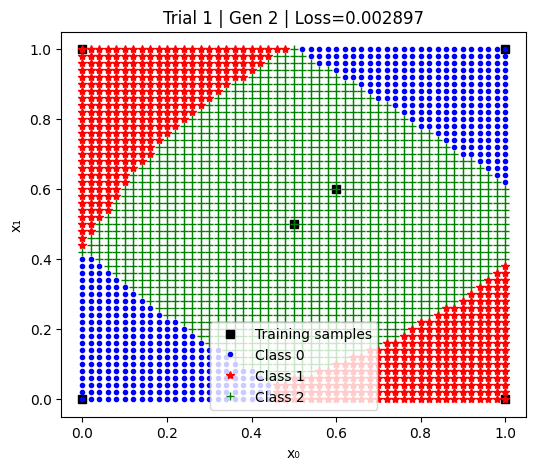

Class-0 (blue) % = 20.30
Class-1 (red)  % = 22.61
Class-2 (green)% = 57.09
--- New Global Best Found! ---
Time taken for this success: 14 secs
Trial 1 completed in 2 mins 52 secs

************************** Trial # = 2 started at 13:33:14 **************************
Trial 2: Initializing hyperparameters
Trial 2: Evaluating initial parent
Trial 2: Initial parent value: 0.058253
Trial 2: Starting evolution loop
Trial 2, Gen 1: Starting generation
Trial 2, Gen 1: Offspring value: 0.838180
Trial 2, Gen 1: Offspring rejected
Trial 2, Gen 2: Starting generation
Trial 2, Gen 2: Offspring value: 0.887165
Trial 2, Gen 2: Offspring rejected
Trial 2, Gen 3: Starting generation
Trial 2, Gen 3: Offspring value: 0.388164
Trial 2, Gen 3: Offspring rejected
Trial 2, Gen 4: Starting generation
Trial 2, Gen 4: Offspring value: 1.131401
Trial 2, Gen 4: Offspring rejected
Trial 2, Gen 5: Starting generation
Trial 2, Gen 5: Offspring value: 1.071190
Trial 2, Gen 5: Offspring rejected
Trial 2, Gen 6: Startin

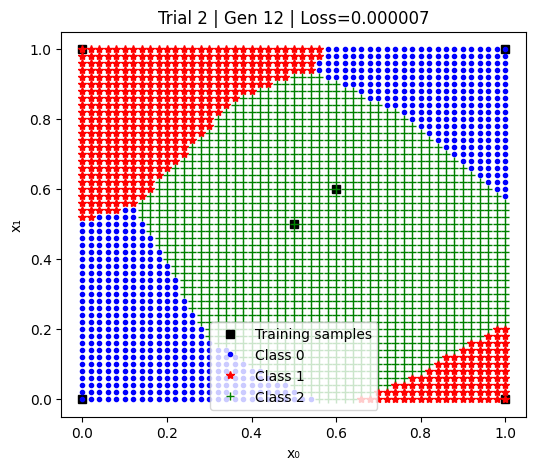

Class-0 (blue) % = 25.87
Class-1 (red)  % = 19.22
Class-2 (green)% = 54.90
--- New Global Best Found! ---
Time taken for this success: 48 secs
Trial 2 completed in 3 mins 29 secs

************************** Trial # = 3 started at 13:36:43 **************************
Trial 3: Initializing hyperparameters
Trial 3: Evaluating initial parent
Trial 3: Initial parent value: 0.879891
Trial 3: Starting evolution loop
Trial 3, Gen 1: Starting generation
Trial 3, Gen 1: Offspring value: 0.022657
Trial 3, Gen 1: Offspring accepted, new parent value: 0.022657
Trial 3, Gen 2: Starting generation
Trial 3, Gen 2: Offspring value: 1.026818
Trial 3, Gen 2: Offspring rejected
Trial 3, Gen 3: Starting generation
Trial 3, Gen 3: Offspring value: 0.018644
Trial 3, Gen 3: Offspring accepted, new parent value: 0.018644
Trial 3, Gen 4: Starting generation
Trial 3, Gen 4: Offspring value: 0.047508
Trial 3, Gen 4: Offspring rejected
Trial 3, Gen 5: Starting generation
Trial 3, Gen 5: Offspring value: 0.001315
Tr

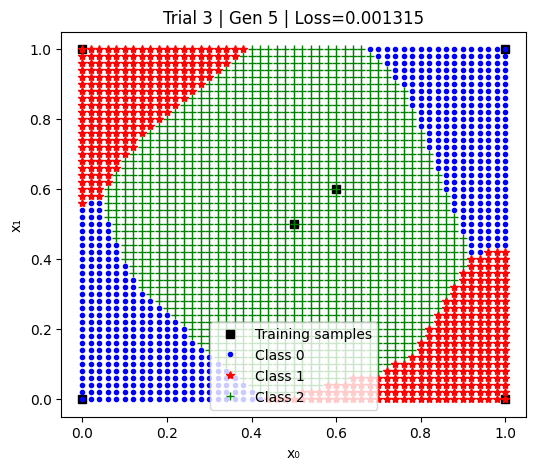

Class-0 (blue) % = 22.65
Class-1 (red)  % = 18.38
Class-2 (green)% = 58.98
Time taken for this success: 26 secs
Trial 3 completed in 3 mins 3 secs

Total runtime for all trials: 9 mins 25 secs

System Success = 100.00%
Average # of generations used = 6

GLOBAL BEST MODEL FOUND
  • Trial #: 2
  • Generation #: 12
  • Best Loss (Eval): 0.00000703
  • Params:
#neurons=16, lr=0.330, bsize=2, actF=leaky_relu, epochs=500, optim=RMSprop, Eval=0.000007


In [20]:
# constants
MaxGen     = 35      # generations per trial
MaxTrial   = 3       # number of independent trials
numVar     = 6       # number of hyperparameters

# initial step size and adjustment ratio
stepSize_i = 0.82    # initial step size
stepSize_r = 0.82    # step size ratio (Rechenberg constant)

totgen     = 0
foundCnt   = 0
objfunc    = XOR3_eval  # link to objective function

print("[#neurons, lr, bsize, actfun, lossfun, optmzr]")

model = None

overall_start = time.time()

global_best_val = float('inf')
global_best_trial = None
global_best_gen = None
global_best_params = None

for trial in range(MaxTrial):
    trial_start = time.time()
    trial_num = trial + 1
    print(f"\n************************** Trial # = {trial_num} started at {time.strftime('%H:%M:%S')} **************************")
    print(f"Trial {trial_num}: Initializing hyperparameters")

    best_p_val_trial = float('inf')

    # --- initialize hyperparameters (start point) ---
    hparams = [
        (np.random.randint(2, 16), 2, 16),                 # hidden neurons
        (round(np.random.uniform(0.01, 1.5), 2), 0.01, 1.5), # learning rate
        (np.random.randint(1, 5), 1, 5),                   # batch size
        (np.random.randint(0, len(act_func)), 0, len(act_func)-1), # activation
        (np.random.randint(100, 501), 100, 500),            # loss (epochs)
        (np.random.randint(0, len(optimz)), 0, len(optimz)-1) # optimizer
    ]

    xp_initial = np.array([h[0] for h in hparams])

    # --- Call the ES function for this trial ---
    found, p_val, generations, final_xp, final_model = es1115(
        trial=trial_num,
        xp_initial=xp_initial,
        hparams=hparams,
        objfunc=objfunc,
        MaxGen=MaxGen,
        WindowSize=10,
        stepSize_i=stepSize_i,
        stepSize_r=stepSize_r,
        numVar=numVar
    )

    if found:
        success_time = time.time()
        print(f"\nTrial {trial_num}: Acceptable solution found after {generations} generations at {time.strftime('%H:%M:%S')}")
        print_HP_found(final_xp, p_val)

        plot_XOR3_decision_boundary(final_model, title=f"Trial {trial_num} | Gen {generations} | Loss={p_val:.6f}")

        # Local (trial) best save
        if p_val < best_p_val_trial:
            best_p_val_trial = p_val
            save_model(final_model, f"bestXOR_trial{trial_num}.keras")

        # Global best comparison
        if p_val < global_best_val:
            print("--- New Global Best Found! ---")
            global_best_val = p_val
            global_best_trial = trial_num
            global_best_gen = generations
            global_best_params = final_xp.copy()
            save_model(final_model, "bestXOR.keras")  # overwrite global best

        totgen += generations
        foundCnt += 1
        print(f"Time taken for this success: {format_time(success_time - trial_start)}")
    else:
        print(f"\nTrial {trial_num}: No acceptable solution found after {MaxGen} generations.")


    trial_end = time.time()
    print(f"Trial {trial_num} completed in {format_time(trial_end - trial_start)}")
    # end of one trial

# --- Final Summary ---
overall_end = time.time()
print(f"\nTotal runtime for all trials: {format_time(overall_end - overall_start)}")

if MaxTrial > 0:
    print(f"\nSystem Success = {foundCnt / MaxTrial * 100:.2f}%")
    # Add generations from failed trials
    totgen += (MaxTrial - foundCnt) * MaxGen
    print(f"Average # of generations used = {totgen / MaxTrial:.0f}")

if global_best_trial is not None:
    print("\nGLOBAL BEST MODEL FOUND")
    print(f"  • Trial #: {global_best_trial}")
    print(f"  • Generation #: {global_best_gen}")
    print(f"  • Best Loss (Eval): {global_best_val:.8f}")
    print("  • Params:")
    print_HP_found(global_best_params, global_best_val)
else:
    print("\nNo acceptable solution found across all trials.")

xpoints: [0.  0.  1.  1.  0.5 0.6]
ypoints: [0.  1.  0.  1.  0.5 0.6]


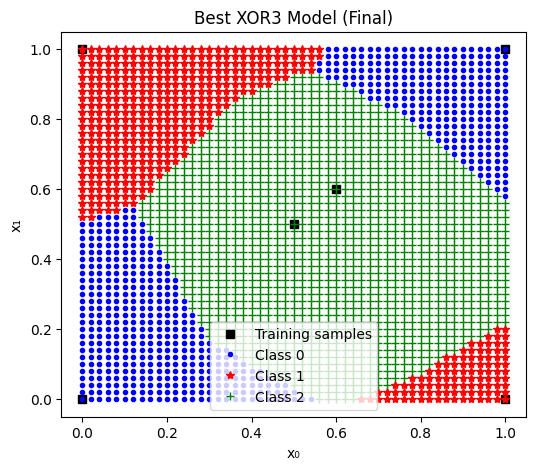

Class-0 (blue) % = 25.87
Class-1 (red)  % = 19.22
Class-2 (green)% = 54.90


In [21]:
plot_XOR3_decision_boundary(model_path="bestXOR.keras", title="Best XOR3 Model (Final)")

In [22]:
print (model.predict(X))
print (model.predict(X, verbose=0).round())
(loss, acc) = model.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

1/1 [==============================] - 0s 23ms/step
[[9.9986660e-01 1.9752699e-06 1.3137209e-04]
 [5.0922581e-06 9.9997401e-01 2.0918176e-05]
 [3.5695816e-06 9.9997997e-01 1.6484923e-05]
 [9.9982113e-01 5.8380615e-06 1.7311441e-04]
 [3.3783013e-04 6.1044984e-06 9.9965608e-01]
 [3.1872821e-04 4.9850282e-06 9.9967635e-01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 0s 42ms/step - loss: 0.0013 - accuracy: 1.0000
loss = 0.0013145471457391977, acc = 1.0


In [23]:
# model save into a file and reloading the model
model.summary()
# model.save('xor3.keras') # the file is stored on the cloud account. Will stay a day

model.load_weights('bestXOR.keras')
print (model.predict(X))
print (model.predict(X, verbose=0).round())
model.evaluate(Xt, yt)

m2 = keras.models.load_model('bestXOR.keras')
m2.summary()
print (m2.predict(X))
print (m2.predict(X, verbose=0).round())
(loss, acc) = m2.evaluate(Xt, yt)
print (f"loss = {loss}, acc = {acc}")

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 16)                48        
                                                                 
 dense_67 (Dense)            (None, 3)                 51        
                                                                 
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 19ms/step
[[9.9999762e-01 3.2026516e-13 2.3882660e-06]
 [4.8857707e-14 1.0000000e+00 9.2798490e-13]
 [4.1264662e-11 9.9999988e-01 1.3291205e-07]
 [9.9999988e-01 1.0760262e-07 2.7803184e-08]
 [3.1310381e-06 3.5966865e-11 9.9999690e-01]
 [1.3780237e-06 4.2810141e-11 9.9999857e-01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
1/1 [==============================] - 0s 26ms/step - los

In [ ]:
# # Using 'categorical_crossentropy'

# model = Sequential([
#     keras.Input(shape=(2,)),
#     Dense(16, activation='relu'),
#     Dense(3, activation='softmax')
# ])
# model.compile(
#   optimizer='rmsprop',
#   loss='categorical_crossentropy', # target labels are 1hot encoded format
#   metrics=['accuracy']
# )

# # Converting y to one-hot encoded format with shape (5,3)
# y_1hot = keras.utils.to_categorical(y, num_classes=3)
# model.fit(X, y_1hot, batch_size=1, epochs=1300, verbose=0)
# print (model.predict(X))
# print (model.predict(X, verbose=0).round())
# yt_1hot = keras.utils.to_categorical(yt, num_classes=3)
# model.evaluate(Xt, yt_1hot)